In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path = [module_path] + sys.path
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
import numpy as np
from tqdm import tqdm
from augmentations import get_aug
import models
from tools import AverageMeter, knn_monitor, Logger, file_exist_check
from datasets import get_dataset
from datetime import datetime
from utils.loggers import *
from utils.metrics import mask_classes
from utils.loggers import CsvLogger
from datasets.utils.continual_dataset import ContinualDataset
from models.utils.continual_model import ContinualModel
from typing import Tuple
import importlib
import matplotlib.pyplot as plt

import yaml
from arguments import Namespace
from types import SimpleNamespace
import arguments
importlib.reload(arguments)
importlib.reload(models)


<module 'models' from '/juice/scr/ananya/continual/UCL/models/__init__.py'>

In [4]:
# Load config

def get_args(config_path):
    args = {
        'debug': True,
        'debug_subset_size': 8,
        'download': True,
        'data_dir': '../Data/',
        'log_dir': False,
        'ckpt_dir': False,
        'device': 'cuda',
        'eval_from': None,
        'hide_progress': True,
        'cl_default': False,
        'validation': True,
    }
    with open(config_path, 'r') as f:
        for key, value in Namespace(yaml.load(f, Loader=yaml.FullLoader)).__dict__.items():
            args[key] = value

    args['aug_kwargs'] = {
        'name': args['model'].name,
        'image_size': args['dataset'].image_size
    }
    args['dataset_kwargs'] = {
        'dataset':args['dataset'].name,
        'data_dir': '../Data/',
        'download': False,
        'debug_subset_size': False,
    }
    args['dataloader_kwargs'] = {
        'drop_last': True,
        'pin_memory': True,
        'num_workers': args['dataset'].num_workers,
    }
    args = SimpleNamespace(**args)
    return args

def load_model(path, args, train_loader=None, dataset_copy=None, device = 'cuda'):
    if train_loader is None or dataset_copy is None:
        dataset_copy = get_dataset(args)
        train_loader, _, _ = dataset_copy.get_data_loaders(args)
    model = models.get_model(
        args, device=device,
        len_train_loader=len(train_loader), transform=dataset_copy.get_transform(args))
    state_dict = torch.load(path)['state_dict']
    updated_state_dict = {}
    for key in state_dict:
        updated_state_dict['net.'+key] = state_dict[key]
    model.load_state_dict(updated_state_dict)
    return model

def load_models(T, args, checkpoints_dir, name_base, device = 'cuda'):
    dataset_copy = get_dataset(args)
    train_loader, _, _ = dataset_copy.get_data_loaders(args)
    models_list = []
    for m in range(T):
        model_path = checkpoints_dir + name_base + str(m) + '.pth'
        models_list.append(load_model(model_path, args, train_loader, dataset_copy))
    return models_list

def get_soup(models_list):
    dataset = get_dataset(args)
    soup_model = models.get_model(args, device, len(train_loader), dataset.get_transform(args))
    soup_dict = soup_model.state_dict()
    other_dicts_list = [model.state_dict() for model in models_list[-3:]]
    for key in soup_dict.keys():
        if soup_dict[key].dtype == torch.int64:
            new_val = other_dicts_list[0][key]
        else:
            new_val = torch.mean(torch.stack([d[key] for d in other_dicts_list], axis=0), axis=0)
        soup_dict[key] = new_val
    soup_model.load_state_dict(soup_dict)
    return soup_model

def get_accs(args, backbone, T, device='cuda'):
    mean_acc = 0.0
    dataset = get_dataset(args)
    accs = []
    for t in range(T):
        train_loader, memory_loader, test_loader = dataset.get_data_loaders(args)
        acc, acc_mask = knn_monitor(backbone, dataset, dataset.memory_loaders[t], dataset.test_loaders[t], device, args.cl_default, task_id=t, k=min(args.train.knn_k, len(memory_loader.dataset)))
        accs.append(acc)
        mean_acc += acc
    mean_acc = mean_acc / float(T)
    print(mean_acc)
    return accs
    
class OutputEnsembler(nn.Module):
    def __init__(self, models):
        super(OutputEnsembler, self).__init__()
        self._models = models
        
    def forward(self, x):
        outputs = torch.stack([model(x) for model in self._models], axis=0)
        return torch.mean(outputs, axis=0)

def make_plots(all_accs):
    average_accs = np.mean(all_accs, axis=1)
    print('average accs:')
    plt.plot(average_accs)
    plt.show()
    print('latest accs:')
    cur_accs = [all_accs[i][i] for i in range(len(all_accs))]
    plt.plot(cur_accs)
    plt.show()
    for i in range(len(all_accs)):
        print('task ' + str(i))
        task_i_accs = all_accs[:, i]
        plt.plot(task_i_accs)
        plt.show()

def get_all_results(checkpoints_dir, name_base, config_path, T):
    args = get_args(config_path)
    print(args)
    models_list = load_models(T, args, checkpoints_dir, name_base)
    all_accs = [get_accs(args, m.net.module.backbone, T) for m in models_list]
    print(np.mean(all_accs, axis=1))
    print(all_accs)
    all_accs = np.array(all_accs)
    make_plots(all_accs)

[[95.88766299 70.57057057 78.8        87.99192735 86.37709773]
 [87.66298897 87.88788789 88.         94.14732593 88.54886476]
 [90.37111334 82.08208208 95.2        96.46821393 87.85784798]
 [90.27081244 80.28028028 89.3        99.19273461 90.72063179]
 [93.58074223 79.97997998 84.6        93.74369324 98.02566634]]
average accs:


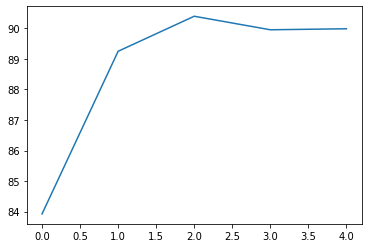

latest accs:


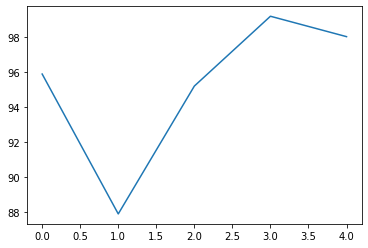

task 0


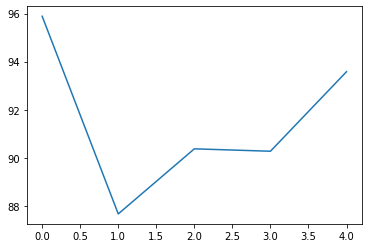

task 1


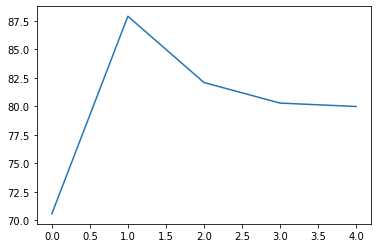

task 2


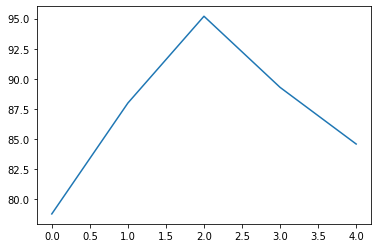

task 3


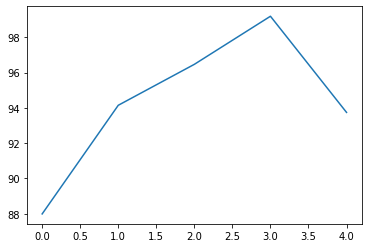

task 4


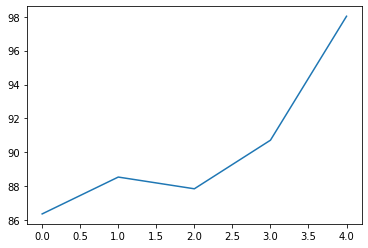

In [33]:
# CIFAR=10, unsupervised
%matplotlib inline 
checkpoints_dir = '/u/scr/ananya/continual/UCL/checkpoints/vanilla_simsiam_cifar10/'
name_base = 'finetune_simsiam-c10-experiment-resnet18_'
config_path = '/u/scr/ananya/continual/logs/vanilla_simsiam_cifar10/simsiam_c10.yaml'
T = 5
get_all_results(checkpoints_dir, name_base, config_path, T)

namespace(aug_kwargs={'name': 'simsiam', 'image_size': 32}, ckpt_dir=False, cl_default=True, data_dir='../Data/', dataloader_kwargs={'drop_last': True, 'pin_memory': True, 'num_workers': 4}, dataset=<arguments.Namespace object at 0x7f46060afdc0>, dataset_kwargs={'dataset': 'seq-cifar10', 'data_dir': '../Data/', 'download': False, 'debug_subset_size': False}, debug=True, debug_subset_size=8, device='cuda', download=True, eval=<arguments.Namespace object at 0x7f46063e1070>, eval_from=None, hide_progress=True, log_dir=False, logger=<arguments.Namespace object at 0x7f46064888b0>, model=<arguments.Namespace object at 0x7f460c07ebb0>, name='simsiam-c10-experiment-resnet18', seed=None, train=<arguments.Namespace object at 0x7f460c02d310>, validation=True)
Files already downloaded and verified
Files already downloaded and verified


/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
76.69485914055582
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
76.85247390094219
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already 

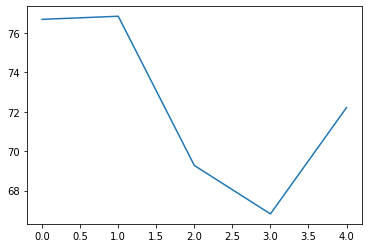

latest accs:


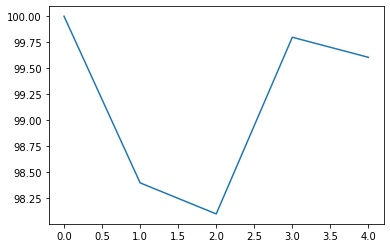

task 0


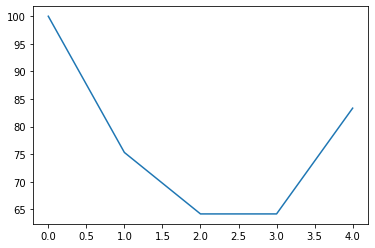

task 1


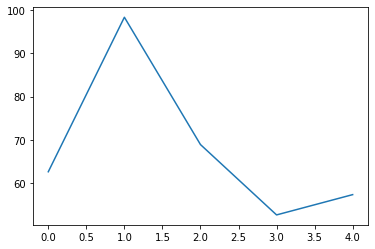

task 2


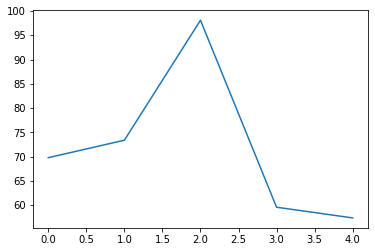

task 3


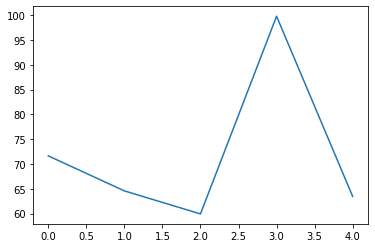

task 4


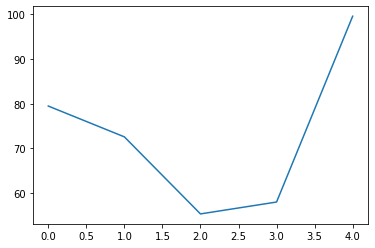

In [35]:
# CIFAR=10, supervised
%matplotlib inline 
checkpoints_dir = '/u/scr/ananya/continual/UCL/checkpoints/simsiam_scl_c10/'
name_base = 'finetune_simsiam-c10-experiment-resnet18_'
config_path = '/u/scr/ananya/continual/logs/simsiam_scl_c10/completed_0429005231_simsiam-c10-experiment-resnet18/simsiam_scl_c10.yaml'
T = 5
get_all_results(checkpoints_dir, name_base, config_path, T)

namespace(aug_kwargs={'name': 'simsiam', 'image_size': 32}, ckpt_dir=False, cl_default=False, data_dir='../Data/', dataloader_kwargs={'drop_last': True, 'pin_memory': True, 'num_workers': 4}, dataset=<arguments.Namespace object at 0x7fb12c1c8e50>, dataset_kwargs={'dataset': 'seq-cifar100', 'data_dir': '../Data/', 'download': False, 'debug_subset_size': False}, debug=True, debug_subset_size=8, device='cuda', download=True, eval=<arguments.Namespace object at 0x7fb12c1c8ca0>, eval_from=None, hide_progress=True, log_dir=False, logger=<arguments.Namespace object at 0x7fb12c1c85b0>, model=<arguments.Namespace object at 0x7fb12c1c8580>, name='simsiam-c100-experiment-resnet18', seed=None, train=<arguments.Namespace object at 0x7fb12c1c8430>, validation=True)
Files already downloaded and verified
Files already downloaded and verified


/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8/site-packages/torchvision/transforms/transforms.py:803: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
68.256469882

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
74.28427640499224
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and ver

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

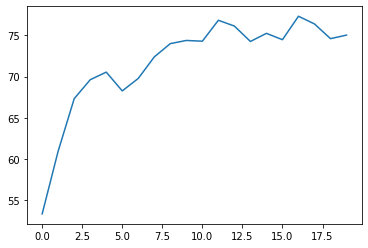

latest accs:


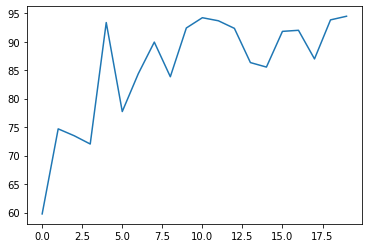

task 0


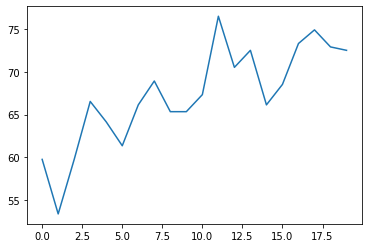

task 1


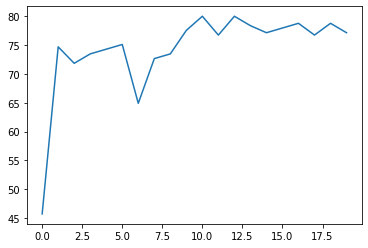

task 2


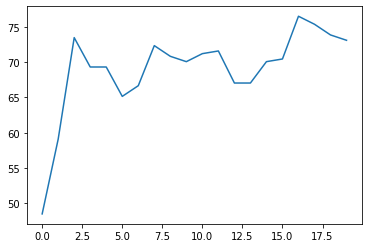

task 3


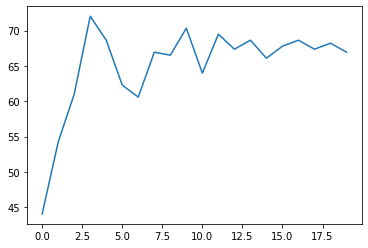

task 4


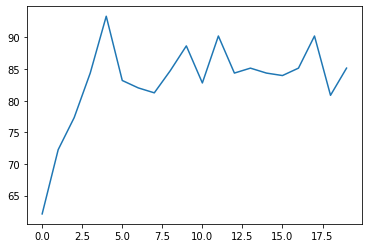

task 5


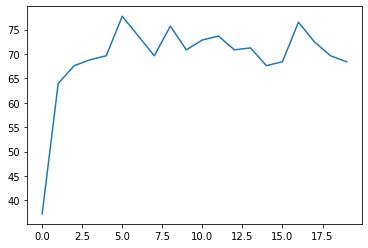

task 6


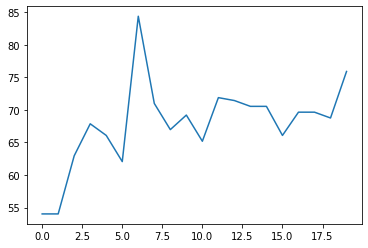

task 7


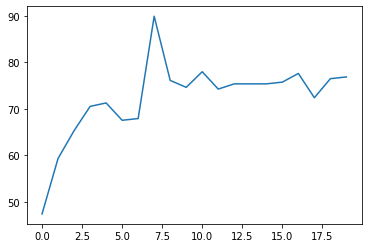

task 8


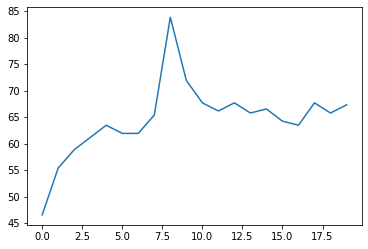

task 9


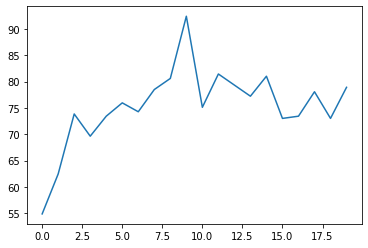

task 10


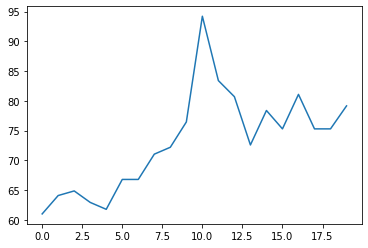

task 11


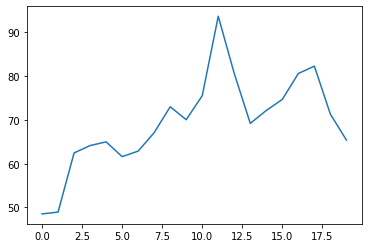

task 12


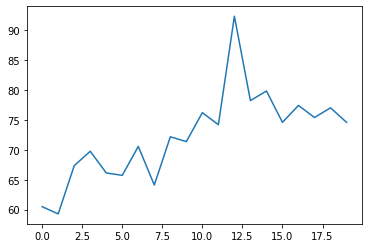

task 13


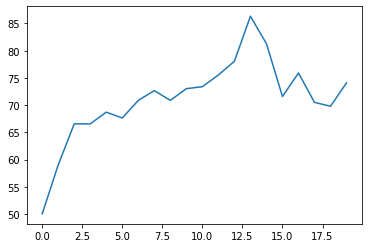

task 14


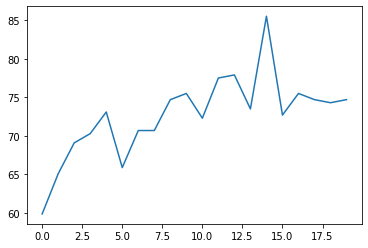

task 15


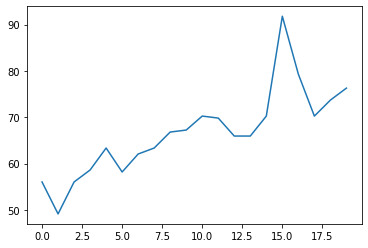

task 16


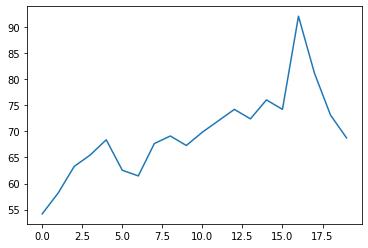

task 17


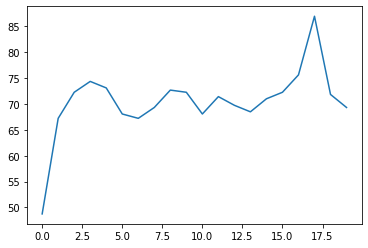

task 18


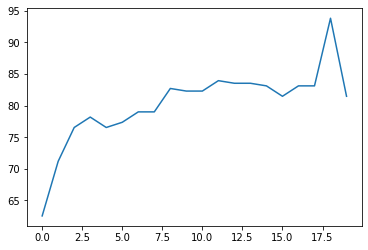

task 19


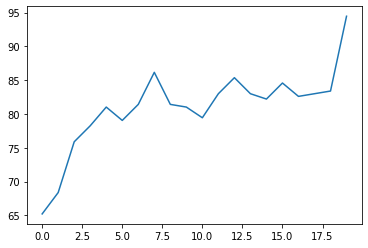

In [5]:
# CIFAR-100, unsupervised
%matplotlib inline 
checkpoints_dir = '/u/scr/ananya/continual/UCL/checkpoints/simsiam_ucl_c100/'
name_base = 'finetune_simsiam-c100-experiment-resnet18_'
config_path = '/u/scr/ananya/continual/logs/simsiam_ucl_c100/completed_0429005204_simsiam-c100-experiment-resnet18/simsiam_c100.yaml'
T = 20
get_all_results(checkpoints_dir, name_base, config_path, T)
# print(args.dataset.name)
# dataset = get_dataset(args)
# print(dataset)
# for t in range(T):
#     print(t)
#     train_loader, memory_loader, test_loader = dataset.get_data_loaders(args)

# Model soups

In [ ]:
# Soup ensembling
soup_model = get_soup(models_list)
mean_acc = get_accs(soup_model.net.module.backbone)

In [ ]:
# Output ensembling
output_ensemble_model = OutputEnsembler(models_list)
mean_acc = get_accs(output_ensemble_model)

array([83.92545173, 89.24941351, 90.39585146, 89.95289182, 89.98601636])